# Prevendo doença cardíaca com machine learning

Passos:
1. Definição do problema
2. Definição dos dados
3. Definir métrica de avaliação
4. Definir as features
5. Escolher o modelo
6. Experimentação

## 1. Definição do problema
Dados parâmetros clínicos, podemos prever se um paciente tem ou não doença cardíaca?

## 2. Dados
Fonte: UCI heart disease dataset.

## 3. Métrica de avaliação
Alvo: >95% de acurácia

## 4. Features
Data dictionary:
* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [5]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

# evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [7]:
df = pd.read_csv("data/heart-disease.csv")

### Exploratory data analysis
1. Que pergunta queremos responser?
2. Quais são os dados e como tratar diferentes tipos?
3. O que está faltando nos dados e o que fazer sobre isso?
4. Quais são os outliers, e por que se importar com eles?
5. Como podemos adicionar, mudar ou remover features para obter mais dos dados?

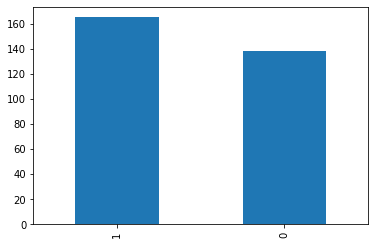

In [13]:
df["target"].value_counts().plot.bar();

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [27]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [29]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


#### Plotando alguns padrões dos dados

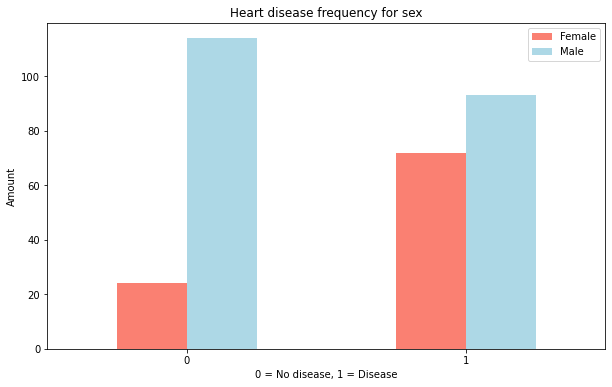

In [35]:
pd.crosstab(df.target, df.sex).plot(kind="bar",
                                    figsize=(10, 6),
                                    color=["salmon", "lightblue"])

plt.title("Heart disease frequency for sex")
plt.xlabel("0 = No disease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0);

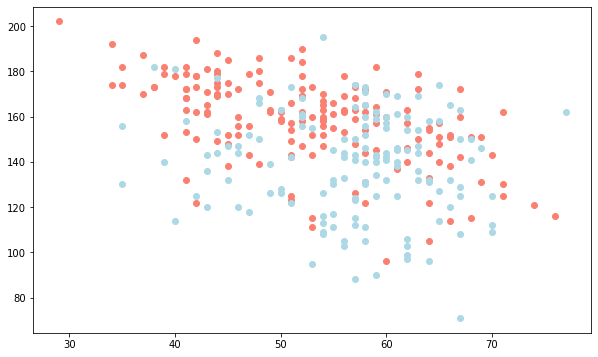

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c="salmon")

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c="lightblue");

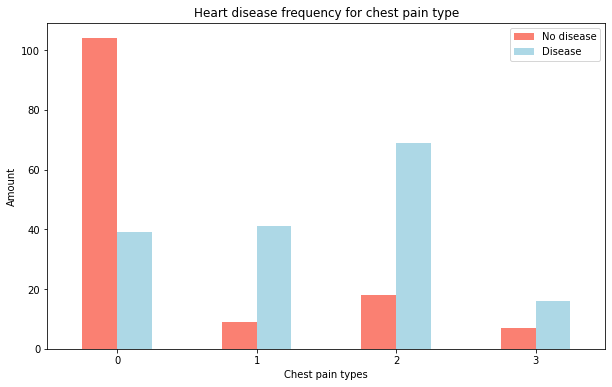

In [38]:
pd.crosstab(df.cp, df.target).plot(kind="bar",
                                    figsize=(10, 6),
                                    color=["salmon", "lightblue"])

plt.title("Heart disease frequency for chest pain type")
plt.xlabel("Chest pain types")
plt.ylabel("Amount")
plt.legend(["No disease", "Disease"])
plt.xticks(rotation=0);

#### Matriz de correlação

In [40]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


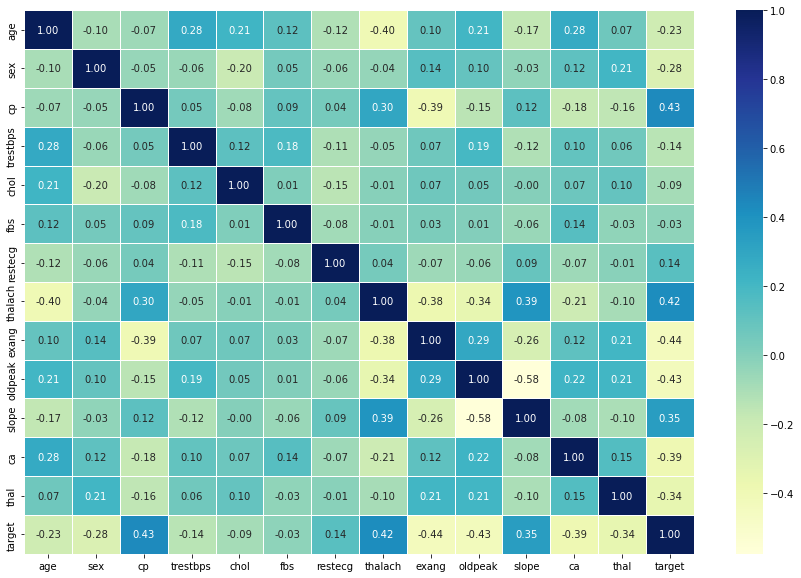

In [43]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, 
                 linewidths=0.5, fmt=".2f",
                 cmap="YlGnBu")

# interpretação
# ultima coluna: conforme a idade aumenta, 
# o target diminui (ou seja, pessoas mais velhas não tem tanta
# incidência de doença cardíaca nesse dataset)

### Modelagem

In [112]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
models = {"Logistic Regression": LogisticRegression(max_iter=500),
          "KNN": KNeighborsClassifier(),
          "RandomForest": RandomForestClassifier()}

# criar função para treinar e avaliar modelos
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Treina e avalia modelos de ML.
    models: dict de modelos sklearn
    X_train: dados de treinamento (sem labels)
    X_test: dados de teste (sem labels)
    y_train: labels de treinamento
    y_test: labels de teste
    """
    
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        # avaliar o modelo e colocar o resultado em model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [86]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

C:\Users\willi\anaconda3\envs\ztm\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8688524590163934,
 'KNN': 0.6065573770491803,
 'RandomForest': 0.819672131147541}

#### Comparação de modelos

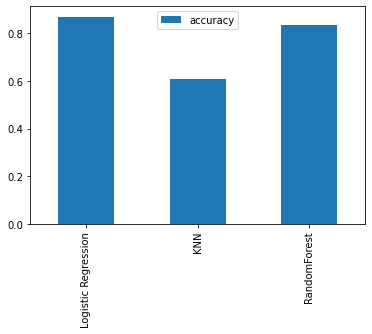

In [68]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

#### Ajustando os modelos

In [84]:
train_scores = []
test_scores = []

neighbors = range(1,21)
knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 70.49%


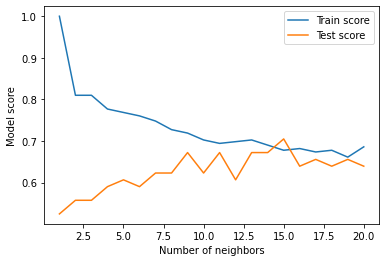

In [85]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

### Ajuste de hiperparâmetros
#### `RandomSearchCV`

In [114]:
# grid para log regression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}
# grid para RF
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [103]:
# ajustar LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_log_reg.fit(X_train, y_train);
rs_log_reg.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.8688524590163934

In [115]:
# ajustar RF
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rf_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_rf.fit(X_train, y_train);
rs_rf.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.8360655737704918

#### `GridSearchCV`

In [118]:
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

gs_log_reg.fit(X_train, y_train)
gs_log_reg.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.7868852459016393

### Avaliar o modelo

C:\Users\willi\anaconda3\envs\ztm\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


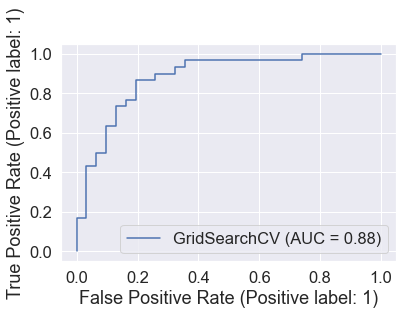

In [126]:
from sklearn.metrics import RocCurveDisplay
y_preds = gs_log_reg.predict(X_test)
plot_roc_curve(gs_log_reg, X_test, y_test);

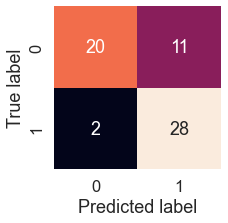

In [134]:
# Import Seaborn
import seaborn as sns
sns.set(font_scale=1.5) # Increase font size
 
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 
    
plot_conf_mat(y_test, y_preds)

In [136]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.65      0.75        31
           1       0.72      0.93      0.81        30

    accuracy                           0.79        61
   macro avg       0.81      0.79      0.78        61
weighted avg       0.82      0.79      0.78        61



#### Calcular métricas com cross-validation

In [145]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train);

In [154]:
cv_acc = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
cv_acc = np.mean(cv_acc)

cv_precision = cross_val_score(clf, X_train, y_train, cv=5, scoring="precision")
cv_precision = np.mean(cv_precision)

cv_recall = cross_val_score(clf, X_train, y_train, cv=5, scoring="recall")
cv_recall = np.mean(cv_recall)

cv_f1= cross_val_score(clf, X_train, y_train, cv=5, scoring="f1")
cv_f1 = np.mean(cv_f1)

clf_score = clf.score(X_test, y_test)

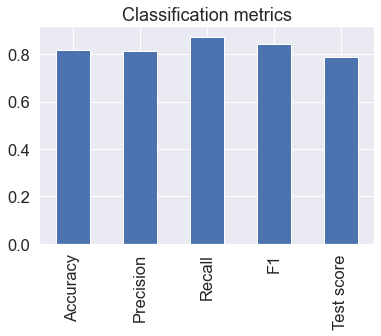

In [164]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1,
                           "Test score": clf_score}, 
                           index=[0])

cv_metrics.T.plot.bar(title="Classification metrics", legend=None);

### Feature importance

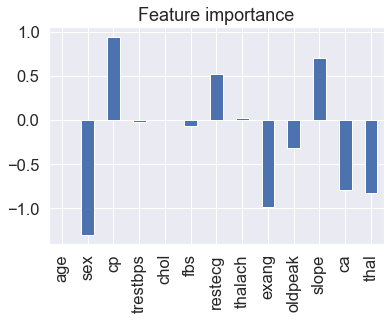

In [169]:
# model-driven EDA
clf.coef_
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))

feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature importance", legend=False);